## <center> GraphSAGE (Graph Sample and Aggregate)

### 一、GraphSAGE 的核心思想

GraphSAGE 是一种归纳学习方法，旨在为图中的节点生成嵌入。它的主要特点是:

1. 采样邻居: 对每个节点，随机采样固定数量的邻居，而不是使用所有邻居。
2. 聚合函数: 使用可学习的聚合函数来聚合邻居信息。
3. 归纳能力: 可以处理动态图和未见过的节点。

GraphSAGE 的更新公式可以表示为:

$$h_v^{k} = \sigma(W^k \cdot \text{CONCAT}(h_v^{k-1}, \text{AGG}_k(\{h_u^{k-1}, \forall u \in {N}(v)\})))$$

其中:
- $h_v^k$ 是节点 v 在第 k 层的表示
- ${N}(v)$ 是节点 v 的采样邻居集合
- $\text{AGG}_k$ 是第 k 层的聚合函数
- $W^k$ 是第 k 层的权重矩阵
- $\sigma$ 是非线性激活函数

Original node features:
[[-0.13030525 -0.04246711 -0.7610942 ]
 [-0.35993176  0.53883773 -0.0230849 ]
 [-0.24097612  1.95682101 -0.59675062]
 [-2.25428035  1.44596374 -1.37483187]
 [-0.35834862 -1.81767113  1.17758536]]

Updated node features:
[[-0.70489767 -0.31432287 -0.22663963 -0.27949512]
 [-0.80744687 -0.32000913 -0.46496272  0.91272254]
 [-0.99171101 -0.92535027 -0.94651762  0.58562889]
 [ 0.30693288 -0.99966257 -0.78241709 -0.79496751]
 [-0.82228364  0.90207342 -0.23198766 -0.99839456]]


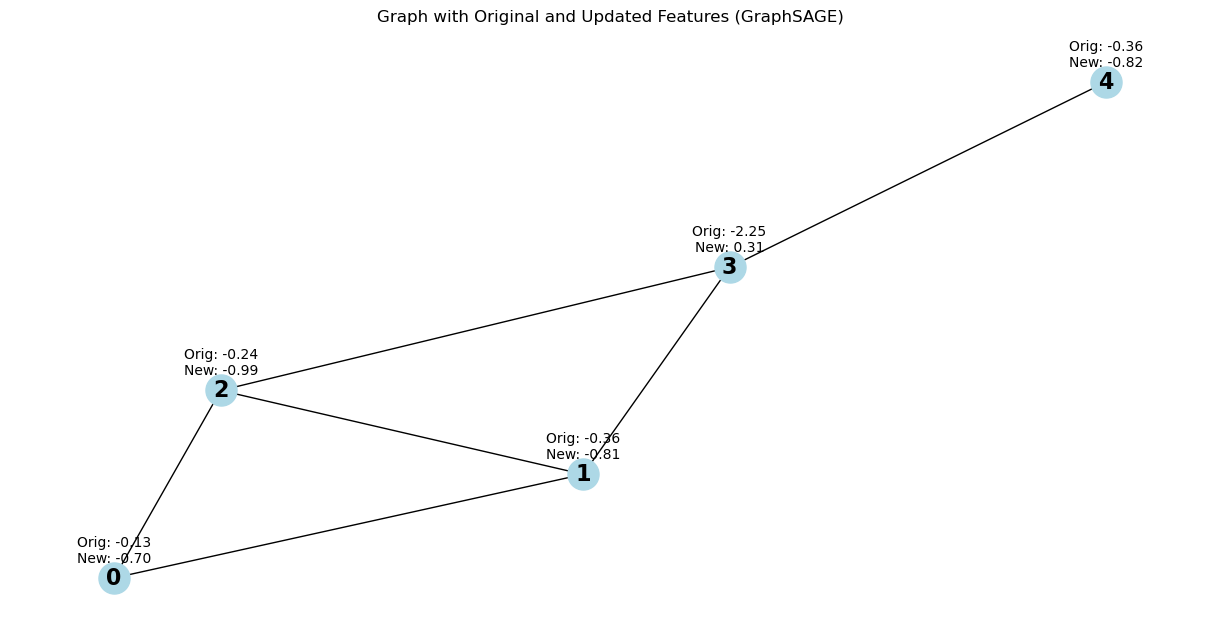

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def create_graph():
    G = nx.Graph()
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)])
    return G

def sample_neighbors(G, nodes, num_samples):
    """Sample a fixed number of neighbors for each node."""
    sampled_neighbors = {}
    for node in nodes:
        neighbors = list(G.neighbors(node))
        if len(neighbors) > num_samples:
            sampled_neighbors[node] = np.random.choice(neighbors, num_samples, replace=False)
        else:
            sampled_neighbors[node] = neighbors + [node] * (num_samples - len(neighbors))
    return sampled_neighbors

def aggregate_mean(neighbor_features):
    """Mean aggregator function."""
    return np.mean(neighbor_features, axis=0)

def graphsage_layer(G, H, W, b, sampled_neighbors):
    """Single GraphSAGE layer."""
    H_next = np.zeros((len(G.nodes), W.shape[0]))
    for v in G.nodes:
        neighbor_h = H[sampled_neighbors[v]]
        agg_neighbor = aggregate_mean(neighbor_h)
        h_v = H[v]
        combined = np.concatenate([h_v, agg_neighbor])
        H_next[v] = np.tanh(np.dot(W, combined) + b)
    return H_next

# Create a simple graph
G = create_graph()

# Initialize node features
num_nodes = len(G.nodes)
input_dim = 3
hidden_dim = 4
H = np.random.randn(num_nodes, input_dim)

# Weight Initialization
W1 = np.random.randn(hidden_dim, input_dim * 2)
b1 = np.zeros(hidden_dim)

# Sample neighbors
num_samples = 2
sampled_neighbors = sample_neighbors(G, G.nodes, num_samples)

# Execute GraphSAGE layer
H_next = graphsage_layer(G, H, W1, b1, sampled_neighbors)

print("Original node features:")
print(H)
print("\nUpdated node features:")
print(H_next)

# Plot the graph with original and updated features
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')

for node, (x, y) in pos.items():
    plt.text(x, y+0.1, f'Orig: {H[node,0]:.2f}\nNew: {H_next[node,0]:.2f}', ha='center', va='center')

plt.title("Graph with Original and Updated Features (GraphSAGE)")
plt.show()